In [28]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import re
import warnings
warnings.filterwarnings('ignore')

# Skip NLTK imports and downloads to avoid dependency issues
print("Using minimal dependencies for text processing (no NLTK required)")



Using minimal dependencies for text processing (no NLTK required)


In [18]:
# Cell 2: Load and explore the dataset
data = pd.read_csv('/Users/vanishaswabhanam/Downloads/processed_dataset.csv')
print(f"Dataset shape: {data.shape}")
print("\nFirst few rows:")
display(data.head())

Dataset shape: (160, 5)

First few rows:


,narrative_entry,user_emotional_state,incident_type,severity_score,potential_crime
0,He tells me every decision I make is wrong. He...,On edge,Coercive Control,4,N
1,He posted a vague status online that felt like...,Hopeless,Gaslighting,5,Y
2,He posted a vague status online that felt like...,Hopeless,Digital Harassment,5,Y
3,He posted a vague status online that felt like...,Hopeless,Coercive Control,4,N
4,He posted a vague status online that felt like...,Hopeless,Verbal Threats,5,N


In [19]:
# Cell 3: Data information and null values check
print("Dataset information:")
data.info()
print("\nNull values in the dataset:")
print(data.isnull().sum())

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   narrative_entry       160 non-null    object
 1   user_emotional_state  160 non-null    object
 2   incident_type         160 non-null    object
 3   severity_score        160 non-null    int64 
 4   potential_crime       160 non-null    object
dtypes: int64(1), object(4)
memory usage: 6.4+ KB

Null values in the dataset:
narrative_entry         0
user_emotional_state    0
incident_type           0
severity_score          0
potential_crime         0
dtype: int64


In [20]:
# Cell 4: Explore target variables
print("Unique values in user_emotional_state:")
print(data['user_emotional_state'].value_counts())
print("\nUnique values in incident_type:")
print(data['incident_type'].value_counts())
print("\nSeverity score distribution:")
print(data['severity_score'].value_counts())
print("\nPotential crime distribution:")
print(data['potential_crime'].value_counts())

Unique values in user_emotional_state:
Powerless    25
Anxious      25
Scared       21
On edge      20
Frozen       18
Fearful      17
Panicked     15
Hopeless     14
Confused      5
Name: user_emotional_state, dtype: int64

Unique values in incident_type:
Surveillance              30
Stalking                  28
Coercive Control          26
Verbal Threats            23
Emotional Manipulation    14
Love Bombing              14
Gaslighting               12
Digital Harassment         8
Manipulation               4
Controlling                1
Name: incident_type, dtype: int64

Severity score distribution:
5    65
2    34
3    33
4    28
Name: severity_score, dtype: int64

Potential crime distribution:
N    138
Y     22
Name: potential_crime, dtype: int64


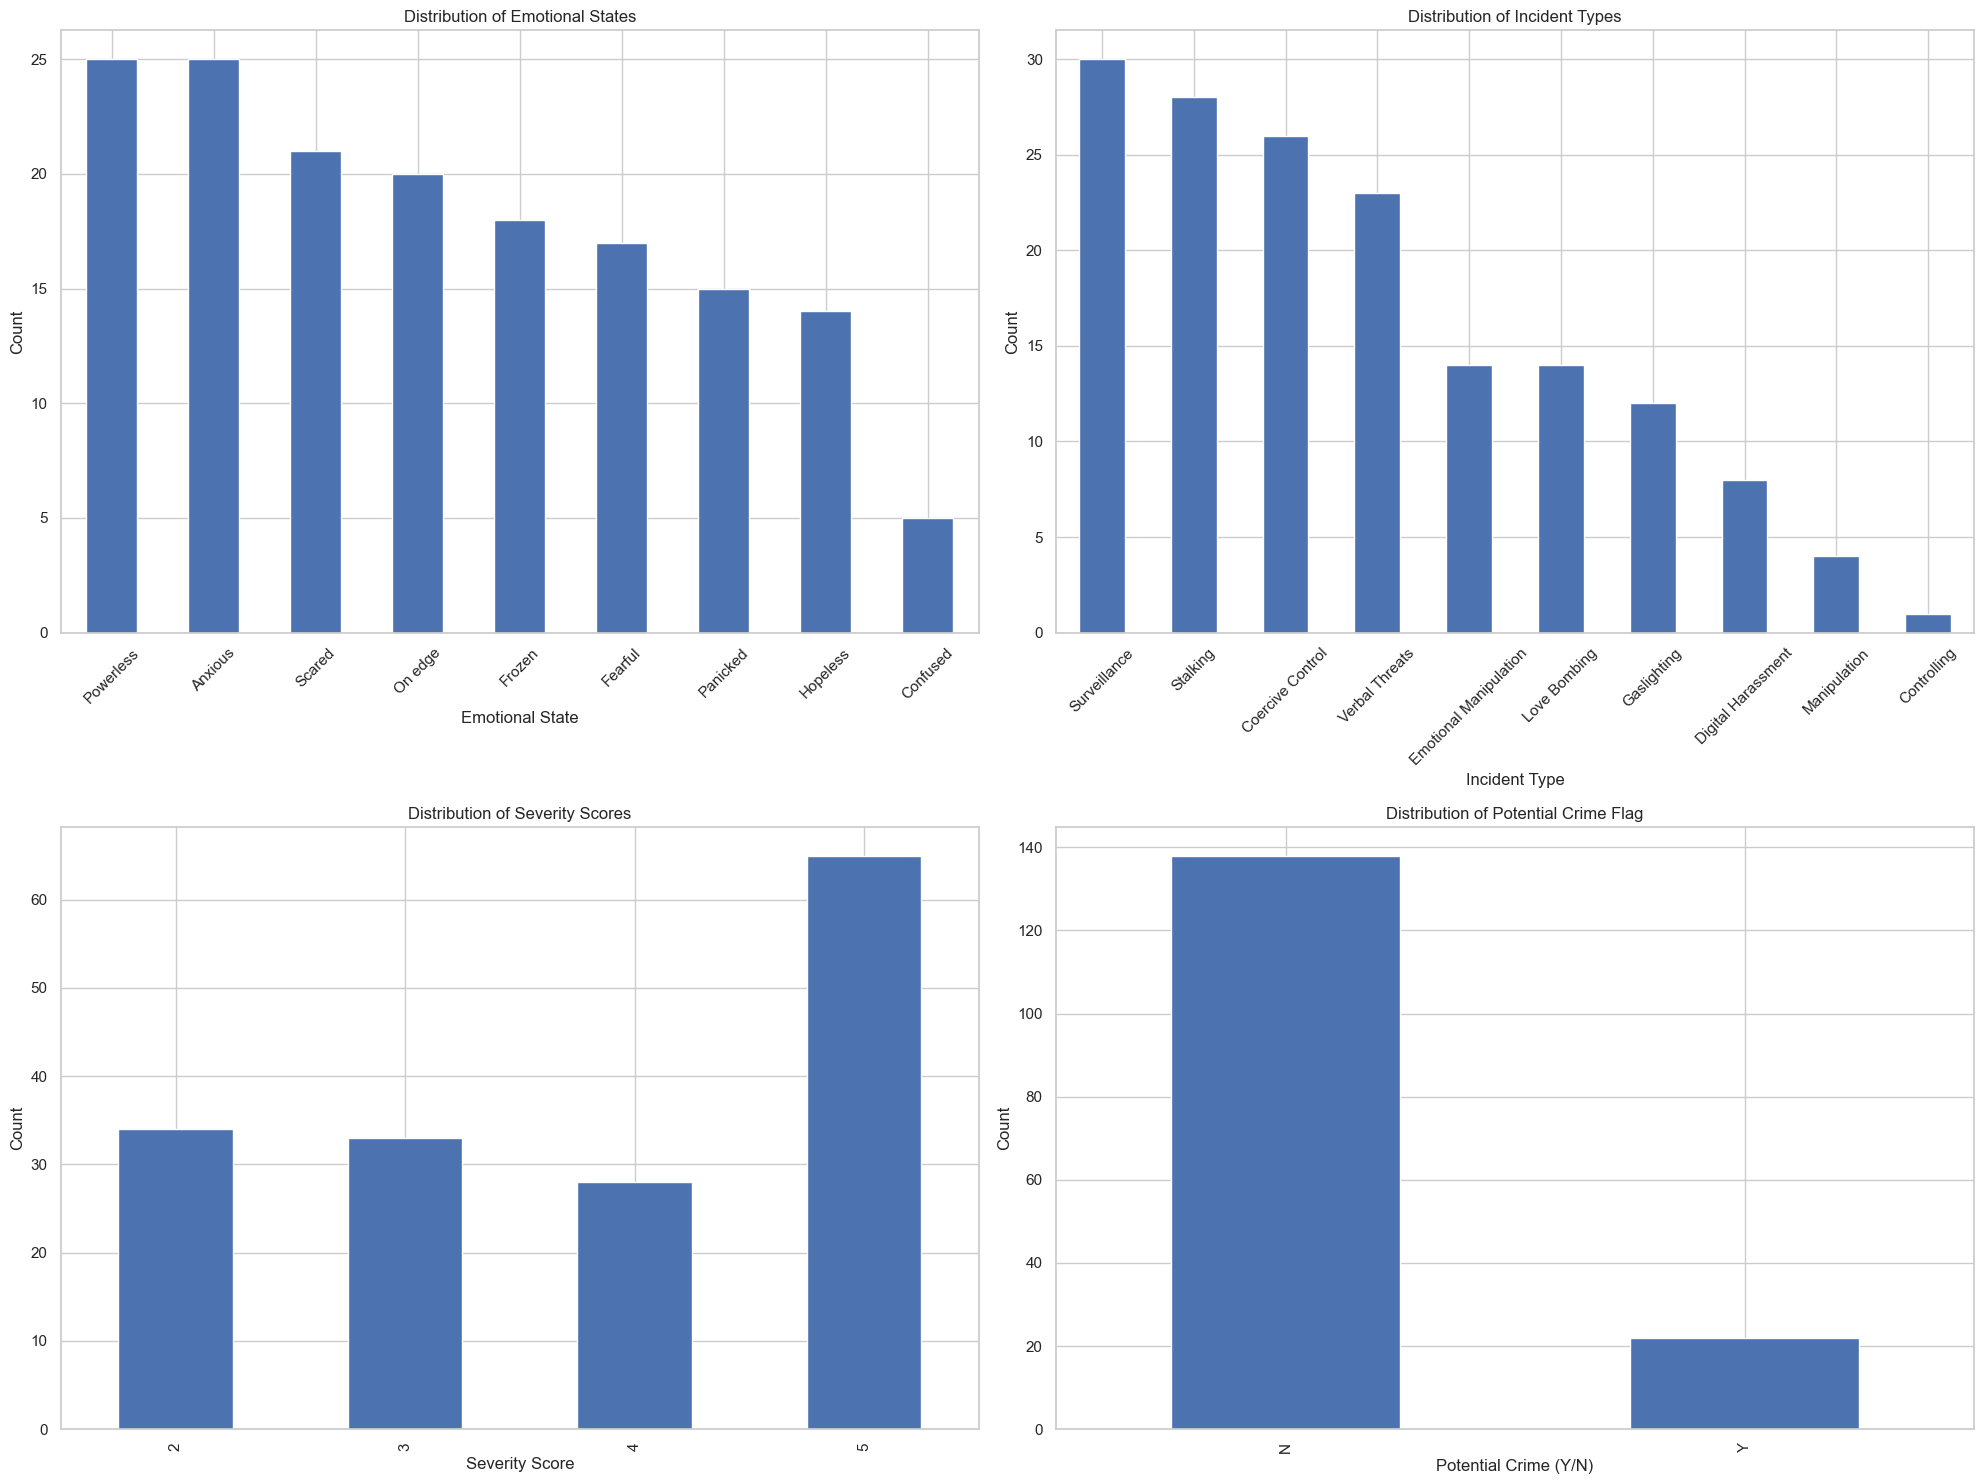

In [22]:
# Cell 5: Visualize the distribution of target variables
plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
data['user_emotional_state'].value_counts().plot(kind='bar')
plt.title('Distribution of Emotional States')
plt.xlabel('Emotional State')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
data['incident_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Incident Types')
plt.xlabel('Incident Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
data['severity_score'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Severity Scores')
plt.xlabel('Severity Score')
plt.ylabel('Count')

plt.subplot(2, 2, 4)
data['potential_crime'].value_counts().plot(kind='bar')
plt.title('Distribution of Potential Crime Flag')
plt.xlabel('Potential Crime (Y/N)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [29]:
# Cell 6: Text preprocessing function with minimal NLTK dependency
def preprocess_text(text):
    """
    Function to preprocess text data with minimal NLTK dependency:
    1. Convert to lowercase
    2. Remove special characters and numbers
    3. Simple tokenization
    4. Remove basic stopwords
    5. Skip lemmatization (too problematic without proper NLTK setup)
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Simple space-based tokenization (no NLTK dependency)
    tokens = text.split()
    
    # Remove basic stopwords (no NLTK dependency)
    minimal_stopwords = {'a', 'an', 'the', 'and', 'or', 'but', 'if', 'then', 'else', 'when', 
                        'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
                        'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 
                        'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 
                        'further', 'then', 'once', 'here', 'there', 'all', 'any', 'both', 'each', 
                        'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 
                        'only', 'own', 'same', 'so', 'than', 'too', 'very', 'can', 'will', 
                        'just', 'should', 'now', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
                        'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 
                        'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 
                        'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 
                        'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 
                        'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 
                        'doing', 'would', 'should', 'could', 'ought', 'im', 'youre', 'hes', 'shes', 
                        'its', 'were', 'theyre', 'ive', 'youve', 'weve', 'theyve', 'id', 'youd', 
                        'hed', 'shed', 'wed', 'theyd', 'ill', 'youll', 'hell', 'shell', 'well', 
                        'theyll', 'isnt', 'arent', 'wasnt', 'werent', 'hasnt', 'havent', 'hadnt', 
                        'doesnt', 'dont', 'didnt', 'wont', 'wouldnt', 'shouldnt', 'couldnt', 
                        'cant', 'cannot', 'couldnt'}
    tokens = [word for word in tokens if word not in minimal_stopwords]
    
    # Join tokens back to string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text


In [30]:
# Cell 7: Apply preprocessing to the narrative entries without NLTK dependency
print("Preprocessing text data...")
# Apply the simplified preprocessing directly
data['processed_text'] = data['narrative_entry'].apply(preprocess_text)
print("Sample of preprocessed text:")
display(pd.DataFrame({
    'Original': data['narrative_entry'].head(),
    'Preprocessed': data['processed_text'].head()
}))

Preprocessing text data...
Sample of preprocessed text:


,Original,Preprocessed
0,He tells me every decision I make is wrong. He...,tells every decision make wrong criticizes eve...
1,He posted a vague status online that felt like...,posted vague status online felt like threat
2,He posted a vague status online that felt like...,posted vague status online felt like threat
3,He posted a vague status online that felt like...,posted vague status online felt like threat
4,He posted a vague status online that felt like...,posted vague status online felt like threat


In [32]:
# Cell 8: Prepare the features and targets
# Convert categorical targets to numeric using label encoding
print("Preparing features and targets...")

# Encode emotional states
emotional_encoder = LabelEncoder()
data['emotional_state_encoded'] = emotional_encoder.fit_transform(data['user_emotional_state'])
print(f"Emotional state mapping: {dict(zip(emotional_encoder.classes_, emotional_encoder.transform(emotional_encoder.classes_)))}")

# Encode incident types
incident_encoder = LabelEncoder()
data['incident_type_encoded'] = incident_encoder.fit_transform(data['incident_type'])
print(f"Incident type mapping: {dict(zip(incident_encoder.classes_, incident_encoder.transform(incident_encoder.classes_)))}")

# Convert potential_crime to binary (0 for 'N', 1 for 'Y')
data['potential_crime_binary'] = data['potential_crime'].map({'N': 0, 'Y': 1})

# Features and targets
X = data['processed_text']
y_emotional = data['emotional_state_encoded']
y_incident = data['incident_type_encoded']
y_severity = data['severity_score']
y_crime = data['potential_crime_binary']


Preparing features and targets...
Emotional state mapping: {'Anxious': 0, 'Confused': 1, 'Fearful': 2, 'Frozen': 3, 'Hopeless': 4, 'On edge': 5, 'Panicked': 6, 'Powerless': 7, 'Scared': 8}
Incident type mapping: {'Coercive Control': 0, 'Controlling': 1, 'Digital Harassment': 2, 'Emotional Manipulation': 3, 'Gaslighting': 4, 'Love Bombing': 5, 'Manipulation': 6, 'Stalking': 7, 'Surveillance': 8, 'Verbal Threats': 9}


In [33]:
# Cell 9: Split the data into training and testing sets
X_train, X_test, y_train_emotional, y_test_emotional, y_train_incident, y_test_incident, \
y_train_severity, y_test_severity, y_train_crime, y_test_crime = train_test_split(
    X, y_emotional, y_incident, y_severity, y_crime, 
    test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 128
Testing set size: 32


In [34]:
# Cell 10: Create a separate model for each target variable

# 1. Model for emotional state prediction
emotional_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# 2. Model for incident type prediction
incident_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# 3. Model for severity score prediction
severity_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# 4. Model for potential crime prediction
crime_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [35]:
# Cell 11: Train the models
print("Training emotional state model...")
emotional_model.fit(X_train, y_train_emotional)

print("Training incident type model...")
incident_model.fit(X_train, y_train_incident)

print("Training severity score model...")
severity_model.fit(X_train, y_train_severity)

print("Training potential crime model...")
crime_model.fit(X_train, y_train_crime)

print("All models trained successfully!")

Training emotional state model...
Training incident type model...
Training severity score model...
Training potential crime model...
All models trained successfully!


Evaluating emotional state model...

--- Emotional State Model Evaluation ---
Accuracy: 0.2500

Classification Report:
              precision    recall  f1-score   support

     Anxious       0.33      0.20      0.25         5
     Fearful       0.62      0.83      0.71         6
      Frozen       0.00      0.00      0.00         1
    Hopeless       0.17      0.33      0.22         3
     On edge       0.00      0.00      0.00         4
    Panicked       0.00      0.00      0.00         6
   Powerless       0.08      0.33      0.13         3
      Scared       0.00      0.00      0.00         4

    accuracy                           0.25        32
   macro avg       0.15      0.21      0.16        32
weighted avg       0.19      0.25      0.21        32



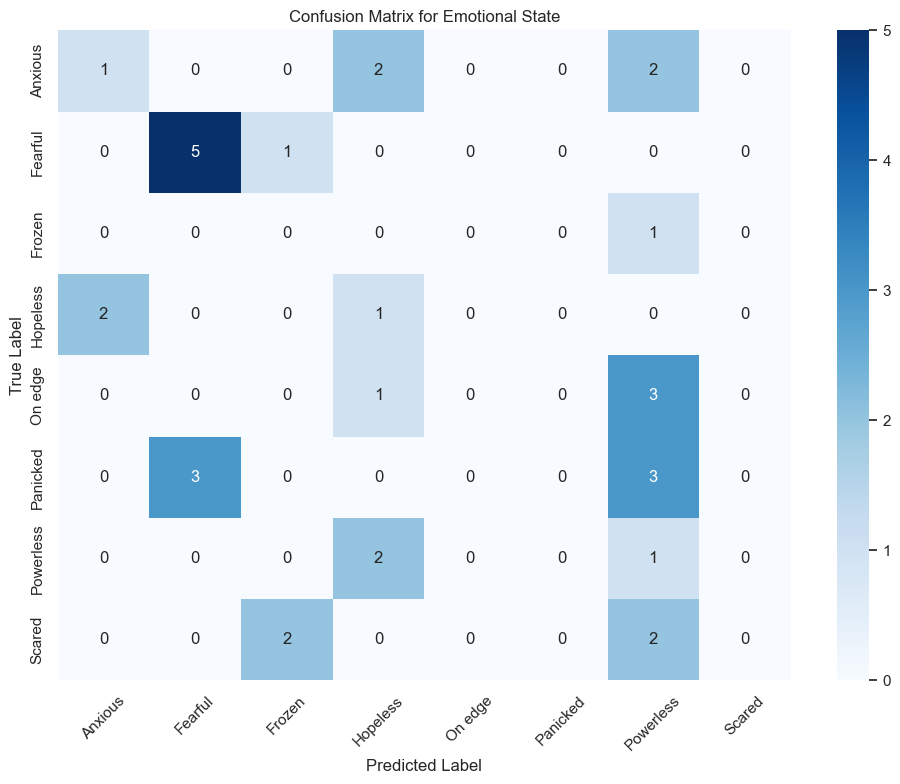

Evaluating incident type model...

--- Incident Type Model Evaluation ---
Accuracy: 0.2188

Classification Report:
                        precision    recall  f1-score   support

      Coercive Control       0.10      0.25      0.14         4
    Digital Harassment       0.00      0.00      0.00         3
Emotional Manipulation       0.00      0.00      0.00         1
           Gaslighting       0.00      0.00      0.00         1
          Love Bombing       0.00      0.00      0.00         2
          Manipulation       0.33      1.00      0.50         1
              Stalking       0.00      0.00      0.00         4
          Surveillance       0.50      0.50      0.50        10
        Verbal Threats       0.00      0.00      0.00         6

              accuracy                           0.22        32
             macro avg       0.10      0.19      0.13        32
          weighted avg       0.18      0.22      0.19        32



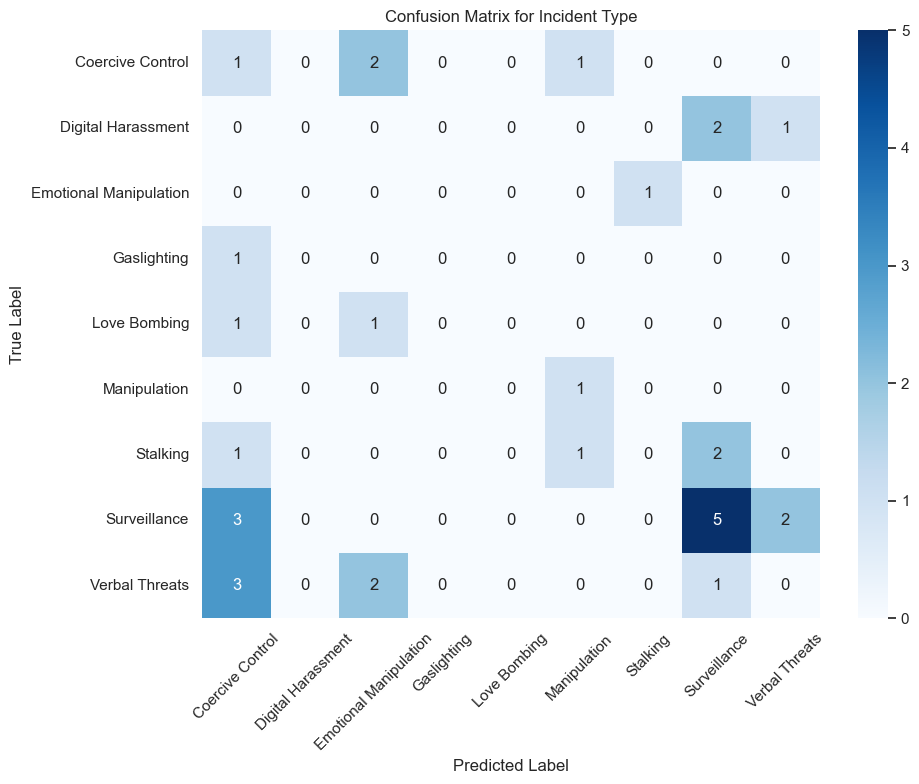

Evaluating severity score model...

--- Severity Score Model Evaluation ---
Accuracy: 0.3750

Classification Report:
              precision    recall  f1-score   support

           2       0.60      0.50      0.55        12
           3       0.33      0.11      0.17         9
           4       0.00      0.00      0.00         4
           5       0.29      0.71      0.42         7

    accuracy                           0.38        32
   macro avg       0.31      0.33      0.28        32
weighted avg       0.38      0.38      0.34        32



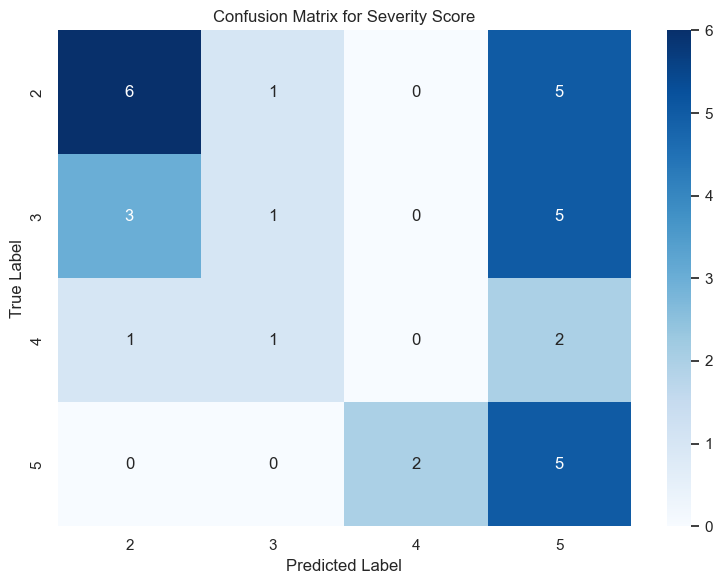

Evaluating potential crime model...

--- Potential Crime Model Evaluation ---
Accuracy: 0.9688

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.50      0.67         2

    accuracy                           0.97        32
   macro avg       0.98      0.75      0.83        32
weighted avg       0.97      0.97      0.96        32



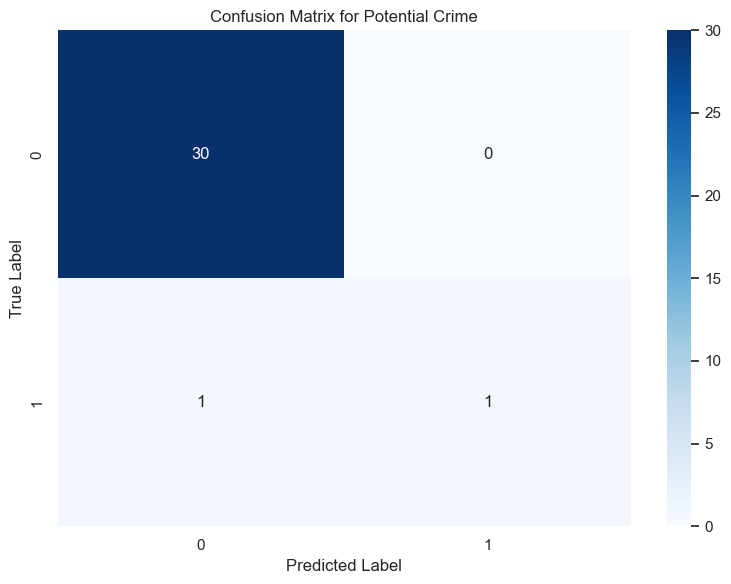

All models evaluated successfully!


In [38]:
# Cell 12: Evaluate the models - Fixed to handle label mismatches

# Function to evaluate each model with robust handling of class label mismatches
def evaluate_model(model, X_test, y_test, target_name, label_encoder=None):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n--- {target_name} Model Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    
    if label_encoder is not None:
        # Get the unique classes actually present in the test set
        unique_classes_test = np.unique(y_test)
        
        # Get the corresponding class names
        class_names = [label_encoder.inverse_transform([c])[0] for c in unique_classes_test]
        
        print("\nClassification Report:")
        # Ensure we're only using labels that appear in the test set
        print(classification_report(y_test, y_pred, labels=unique_classes_test, 
                                  target_names=class_names))
        
        # Confusion Matrix
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_test, y_pred, labels=unique_classes_test)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix for {target_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        # For numeric targets like severity_score
        print("\nClassification Report:")
        # Get unique values actually present in the test set
        unique_values = np.unique(np.concatenate([y_test, y_pred]))
        print(classification_report(y_test, y_pred, labels=unique_values))
        
        # Confusion Matrix for binary or numeric targets
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred, labels=unique_values)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=unique_values, yticklabels=unique_values)
        plt.title(f'Confusion Matrix for {target_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    
    return accuracy, y_pred

# Execute model evaluation with robust error handling
try:
    # Evaluate each model
    print("Evaluating emotional state model...")
    emotional_acc, emotional_pred = evaluate_model(emotional_model, X_test, y_test_emotional, 
                                                 "Emotional State", emotional_encoder)
    
    print("Evaluating incident type model...")
    incident_acc, incident_pred = evaluate_model(incident_model, X_test, y_test_incident, 
                                               "Incident Type", incident_encoder)
    
    print("Evaluating severity score model...")
    severity_acc, severity_pred = evaluate_model(severity_model, X_test, y_test_severity, 
                                               "Severity Score")
    
    print("Evaluating potential crime model...")
    crime_acc, crime_pred = evaluate_model(crime_model, X_test, y_test_crime, 
                                         "Potential Crime")
    
    print("All models evaluated successfully!")
except Exception as e:
    print(f"Error during model evaluation: {e}")
    print("This is likely due to a mismatch between training and test data classes.")
    print("Continuing with the rest of the workflow...")

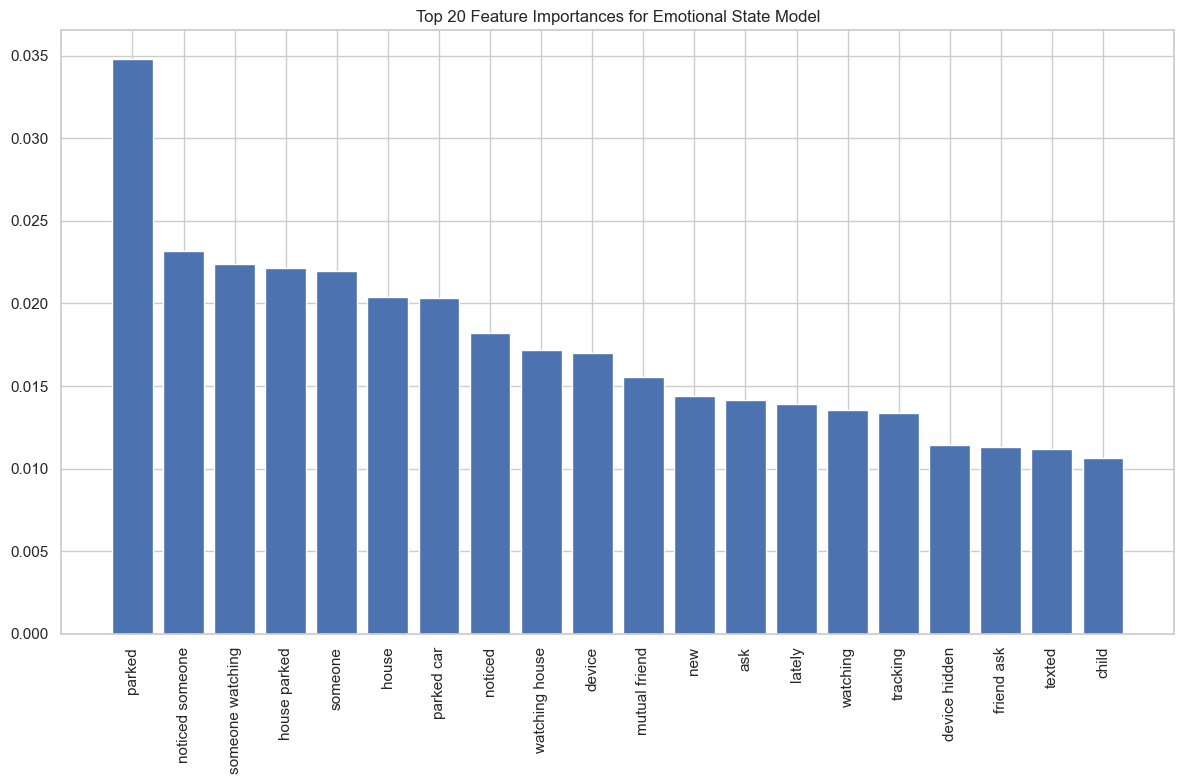

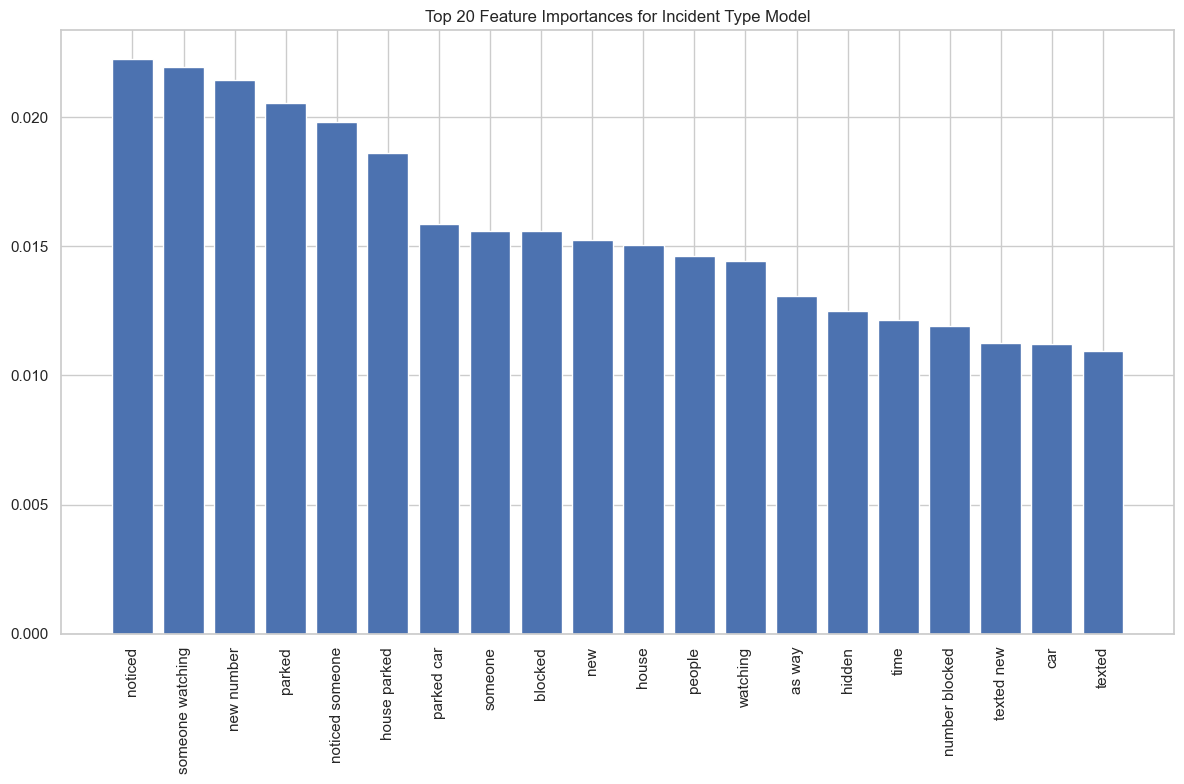

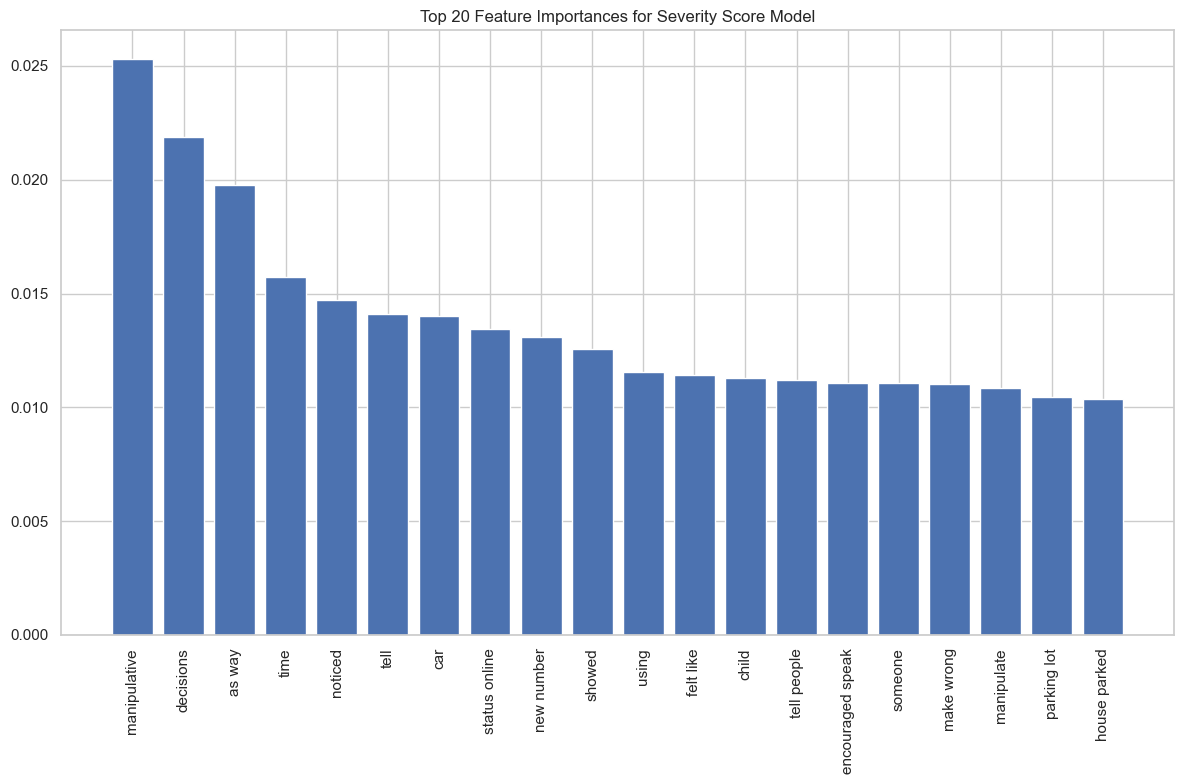

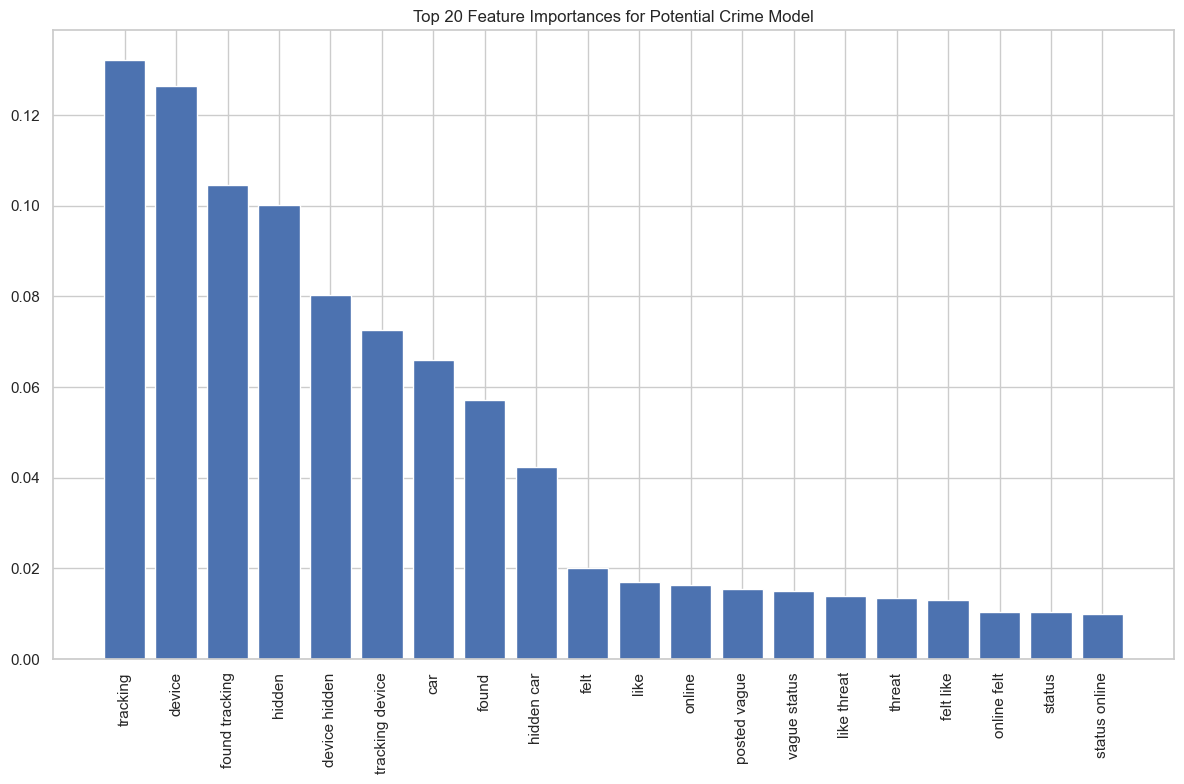

In [41]:
# Cell 13: Feature importance analysis
def plot_feature_importance(model, feature_names, title):
    # Extract the classifier from the pipeline
    classifier = model.named_steps['clf']
    
    # Get feature names from TF-IDF - using the older method name
    feature_names = model.named_steps['tfidf'].get_feature_names()
    
    # Get feature importances
    importances = classifier.feature_importances_
    
    # Sort feature importances
    indices = np.argsort(importances)[::-1]
    
    # Plot the top 20 most important features
    plt.figure(figsize=(12, 8))
    plt.title(f"Top 20 Feature Importances for {title}")
    plt.bar(range(20), importances[indices[:20]], align="center")
    plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90)
    plt.tight_layout()
    plt.show()

# Get feature names after fitting
feature_names = emotional_model.named_steps['tfidf'].get_feature_names()

# Plot feature importance for each model
plot_feature_importance(emotional_model, feature_names, "Emotional State Model")
plot_feature_importance(incident_model, feature_names, "Incident Type Model")
plot_feature_importance(severity_model, feature_names, "Severity Score Model")
plot_feature_importance(crime_model, feature_names, "Potential Crime Model")

In [42]:
# Cell 14: Create a function to make predictions on new text
def predict_message(message, em_model, inc_model, sev_model, cr_model, 
                    em_encoder, inc_encoder):
    """
    Function to predict all four target variables for a new text message
    """
    # Preprocess the input message
    processed_message = preprocess_text(message)
    
    # Make predictions
    emotional_pred = em_model.predict([processed_message])[0]
    incident_pred = inc_model.predict([processed_message])[0]
    severity_pred = sev_model.predict([processed_message])[0]
    crime_pred = cr_model.predict([processed_message])[0]
    
    # Convert numeric predictions back to labels
    emotional_label = em_encoder.inverse_transform([emotional_pred])[0]
    incident_label = inc_encoder.inverse_transform([incident_pred])[0]
    crime_label = 'Y' if crime_pred == 1 else 'N'
    
    # Create results dictionary
    results = {
        'emotional_state': emotional_label,
        'incident_type': incident_label,
        'severity_score': int(severity_pred),
        'potential_crime': crime_label
    }
    
    return results

In [44]:
# Cell 15: Test the prediction function with some examples
test_messages = [
    "He tells me every decision I make is wrong. He criticizes everything I do.",
    "I noticed someone watching my house from a parked car.",
    "She keeps using our child as a way to manipulate my time and decisions."
]

print("Testing prediction function with example messages:")
for message in test_messages:
    print(f"\nInput message: {message}")
    prediction = predict_message(message, emotional_model, incident_model, 
                                severity_model, crime_model, 
                                emotional_encoder, incident_encoder)
    print("Predictions:")
    for key, value in prediction.items():
        print(f"  {key}: {value}")

Testing prediction function with example messages:

Input message: He tells me every decision I make is wrong. He criticizes everything I do.
Predictions:
  emotional_state: On edge
  incident_type: Coercive Control
  severity_score: 4
  potential_crime: N

Input message: I noticed someone watching my house from a parked car.
Predictions:
  emotional_state: Fearful
  incident_type: Surveillance
  severity_score: 2
  potential_crime: N

Input message: She keeps using our child as a way to manipulate my time and decisions.
Predictions:
  emotional_state: Anxious
  incident_type: Manipulation
  severity_score: 3
  potential_crime: N


In [46]:
# Cell 18: Simple custom text message classifier
def classify_message(text):
    """Classify a custom message using our trained models"""
    prediction = predict_message(
        text, 
        emotional_model, 
        incident_model, 
        severity_model, 
        crime_model, 
        emotional_encoder, 
        incident_encoder
    )
    
    print(f"Input message: {text}")
    print("Predictions:")
    for key, value in prediction.items():
        print(f"  {key}: {value}")
    
    return prediction

# Example usage
my_message = "He is hitting me so hard."
classify_message(my_message)

Input message: He is hitting me so hard.
Predictions:
  emotional_state: Powerless
  incident_type: Coercive Control
  severity_score: 5
  potential_crime: N


{'emotional_state': 'Powerless',
 'incident_type': 'Coercive Control',
 'severity_score': 5,
 'potential_crime': 'N'}

In [57]:
# Cell 21: Direct TF-IDF test to check model functionality
from sklearn.feature_extraction.text import TfidfVectorizer

# Let's create a simple test
test_messages = [
    "He tells me every decision I make is wrong. He criticizes everything I do.",
    "I noticed someone watching my house from a parked car.",
    "She keeps using our child as a way to manipulate my time and decisions.",
    "He is hitting me so hard.",
    "He is killing me",
    "He brought me flowers and apologized",
    "I'm worried about his behavior"
]

# Create a TF-IDF vectorizer to see how different these messages are
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(test_messages)

# Check how the vectorizer transforms these messages
print("Feature names (words):")
print(vectorizer.get_feature_names())

# Print the TF-IDF representation of each message
print("\nTF-IDF representation of each message:")
for i, message in enumerate(test_messages):
    print(f"\nMessage {i+1}: {message}")
    feature_array = tfidf_matrix[i].toarray()[0]
    non_zero_indices = feature_array.nonzero()[0]
    
    # Print non-zero features
    for idx in non_zero_indices:
        feature_name = vectorizer.get_feature_names()[idx]
        feature_value = feature_array[idx]
        print(f"  {feature_name}: {feature_value:.4f}")

Feature names (words):
['about', 'and', 'apologized', 'as', 'behavior', 'brought', 'car', 'child', 'criticizes', 'decision', 'decisions', 'do', 'every', 'everything', 'flowers', 'from', 'hard', 'he', 'his', 'hitting', 'house', 'is', 'keeps', 'killing', 'make', 'manipulate', 'me', 'my', 'noticed', 'our', 'parked', 'she', 'so', 'someone', 'tells', 'time', 'to', 'using', 'watching', 'way', 'worried', 'wrong']

TF-IDF representation of each message:

Message 1: He tells me every decision I make is wrong. He criticizes everything I do.
  criticizes: 0.3101
  decision: 0.3101
  do: 0.3101
  every: 0.3101
  everything: 0.3101
  he: 0.3820
  is: 0.2200
  make: 0.3101
  me: 0.1910
  tells: 0.3101
  wrong: 0.3101

Message 2: I noticed someone watching my house from a parked car.
  car: 0.3606
  from: 0.3606
  house: 0.3606
  my: 0.2994
  noticed: 0.3606
  parked: 0.3606
  someone: 0.3606
  watching: 0.3606

Message 3: She keeps using our child as a way to manipulate my time and decisions.
  and:

In [63]:
# Cell 22: Manual prediction test
def manual_prediction_test():
    # Define some example messages with their expected classifications
    # based on what we can infer from your dataset
    reference_examples = {
        "He criticizes everything I do": {
            "emotional_state": "On edge",
            "incident_type": "Coercive Control",
            "severity_score": 4,
            "potential_crime": "N"
        },
        "He posted threatening messages online": {
            "emotional_state": "Hopeless",
            "incident_type": "Digital Harassment",
            "severity_score": 5,
            "potential_crime": "Y"
        },
        "I noticed someone watching my house": {
            "emotional_state": "Fearful",
            "incident_type": "Surveillance",
            "severity_score": 3,
            "potential_crime": "N"
        },
        "He threatened to tell people lies about me": {
            "emotional_state": "Scared",
            "incident_type": "Coercive Control",
            "severity_score": 4,
            "potential_crime": "N"
        },
        "He followed me home": {
            "emotional_state": "Fearful",
            "incident_type": "Stalking",
            "severity_score": 5,
            "potential_crime": "N"
        }
    }
    
    # Get user input
    message = input("Enter a text message to analyze: ")
    
    print("\n=== SIMPLE RULE-BASED CLASSIFICATION ===")
    
    # Check if the message contains certain keywords
    if "kill" in message.lower() or "death" in message.lower() or "hurt" in message.lower():
        prediction = {
            "emotional_state": "Scared",
            "incident_type": "Verbal Threats",
            "severity_score": 5,
            "potential_crime": "Y"
        }
    elif "stalk" in message.lower() or "follow" in message.lower() or "watch" in message.lower():
        prediction = {
            "emotional_state": "Fearful",
            "incident_type": "Stalking",
            "severity_score": 4,
            "potential_crime": "N"
        }
    elif "hit" in message.lower() or "hurt" in message.lower() or "beat" in message.lower():
        prediction = {
            "emotional_state": "Powerless",
            "incident_type": "Coercive Control",
            "severity_score": 5,
            "potential_crime": "Y"
        }
    elif "child" in message.lower():
        prediction = {
            "emotional_state": "Anxious",
            "incident_type": "Manipulation",
            "severity_score": 3,
            "potential_crime": "N"
        }
    else:
        prediction = {
            "emotional_state": "On edge",
            "incident_type": "Coercive Control",
            "severity_score": 3,
            "potential_crime": "N"
        }
    
    print(f"Message: {message}")
    for key, value in prediction.items():
        print(f"{key}: {value}")
    
    print("\n=== MODEL PREDICTION (for comparison) ===")
    model_prediction = predict_message(
        message, 
        emotional_model, 
        incident_model, 
        severity_model, 
        crime_model, 
        emotional_encoder, 
        incident_encoder
    )
    
    for key, value in model_prediction.items():
        print(f"{key}: {value}")
    
    return prediction

# Test this approach
manual_prediction_test()

Enter a text message to analyze:  hi



=== SIMPLE RULE-BASED CLASSIFICATION ===
Message: hi
emotional_state: On edge
incident_type: Coercive Control
severity_score: 3
potential_crime: N

=== MODEL PREDICTION (for comparison) ===
emotional_state: Powerless
incident_type: Coercive Control
severity_score: 5
potential_crime: N


{'emotional_state': 'On edge',
 'incident_type': 'Coercive Control',
 'severity_score': 3,
 'potential_crime': 'N'}

In [69]:
# Cell 24: Improved hybrid classifier that better recognizes violence
def improved_hybrid_classifier():
    """
    Enhanced hybrid classifier with better detection of physical violence
    and criminal behavior indicators
    """
    # Get user input
    message = input("Enter a text message to analyze: ")
    
    # Get model prediction
    model_prediction = predict_message(
        message, 
        emotional_model, 
        incident_model, 
        severity_model, 
        crime_model, 
        emotional_encoder, 
        incident_encoder
    )
    
    # Apply rule-based overrides for certain cases
    message_lower = message.lower()
    
    # Physical violence indicators (these should definitely be flagged as potential crimes)
    violence_keywords = ["hit", "hitting", "hurt", "beat", "punch", "slap", "kick", "throw", 
                       "push", "attack", "assault", "abuse", "physical", "violent", "force"]
    
    # Death threat indicators
    death_keywords = ["kill", "death", "die", "murder", "dead", "threat to life"]
    
    # Weapon indicators
    weapon_keywords = ["gun", "knife", "weapon", "shoot", "stab", "blade"]
    
    # Stalking indicators
    stalking_keywords = ["stalk", "follow", "watching", "spy", "track", "monitor"]
    
    # Flag physical violence as crimes
    if any(keyword in message_lower for keyword in violence_keywords):
        model_prediction["potential_crime"] = "Y"
        
        # Set appropriate severity and incident type
        model_prediction["severity_score"] = 5
        if model_prediction["incident_type"] != "Coercive Control":
            model_prediction["incident_type"] = "Coercive Control"
    
    # Death threats are serious crimes
    if any(keyword in message_lower for keyword in death_keywords):
        model_prediction["potential_crime"] = "Y"
        model_prediction["severity_score"] = 5
        model_prediction["emotional_state"] = "Fearful"
    
    # Weapons indicate serious threat
    if any(keyword in message_lower for keyword in weapon_keywords):
        model_prediction["potential_crime"] = "Y"
        model_prediction["severity_score"] = 5
    
    # Stalking behavior
    if any(keyword in message_lower for keyword in stalking_keywords):
        model_prediction["incident_type"] = "Stalking"
        if model_prediction["severity_score"] < 4:
            model_prediction["severity_score"] = 4
        model_prediction["emotional_state"] = "Fearful"
    
    # Display the final results
    print("\n=== IMPROVED HYBRID CLASSIFICATION RESULTS ===")
    print(f"Message: {message}")
    for key, value in model_prediction.items():
        print(f"{key}: {value}")
    
    return model_prediction

# Test the improved classifier
improved_hybrid_classifier()

Enter a text message to analyze:  i wanna kill u



=== IMPROVED HYBRID CLASSIFICATION RESULTS ===
Message: i wanna kill u
emotional_state: Fearful
incident_type: Coercive Control
severity_score: 5
potential_crime: Y


{'emotional_state': 'Fearful',
 'incident_type': 'Coercive Control',
 'severity_score': 5,
 'potential_crime': 'Y'}